In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score,  roc_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import KFold

from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import K2Score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, K2Score
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BayesianEstimator

from scipy import stats
from scipy.stats import entropy
from tqdm import tqdm
from ucimlrepo import fetch_ucirepo

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets 


# Define features and target
y = (y['Diagnosis'].isin(['M'])).astype(int)  # 1 for M, 0 for B

data = pd.concat([X, y.rename('Diagnosis')], axis=1)

In [12]:
# Prepare the data by converting continuous variables to categorical
def get_bin_edges(series, bins=4):
    non_nan = series.dropna()
    if len(non_nan) == 0:
        return None
    
    bin_edges = np.percentile(non_nan, np.linspace(0, 100, bins + 1))
    return bin_edges

def discretize_with_nan(series, bins, print_ranges=False):
    non_nan = series.dropna()
    if len(non_nan) == 0:
        return pd.Series(index=series.index)
    
    bin_edges = np.percentile(non_nan, np.linspace(0, 100, bins + 1))
    bin_edges[0] = -np.inf
    bin_edges[-1] = np.inf
    
    labels = ['Low', 'Medium-Low', 'Medium-High', 'High']
    discretized = pd.cut(series, bins=bin_edges, labels=labels, include_lowest=True)
    discretized = discretized.cat.add_categories('Unknown')
    discretized = discretized.fillna('Unknown')

    if print_ranges:
        print(series.name)
        print(f"Low: <= {bin_edges[1]:.2f}")
        print(f"Medium-Low: {bin_edges[1]:.2f} to {bin_edges[2]:.2f}")
        print(f"Medium-High: {bin_edges[2]:.2f} to {bin_edges[3]:.2f}")
        print(f"High: > {bin_edges[3]:.2f}")
        print()
    
    return discretized

for var in X.columns:
    if var in data.columns:
        data[var] = discretize_with_nan(data[var], bins=4, print_ranges=True)

radius1
Low: <= 11.70
Medium-Low: 11.70 to 13.37
Medium-High: 13.37 to 15.78
High: > 15.78

texture1
Low: <= 16.17
Medium-Low: 16.17 to 18.84
Medium-High: 18.84 to 21.80
High: > 21.80

perimeter1
Low: <= 75.17
Medium-Low: 75.17 to 86.24
Medium-High: 86.24 to 104.10
High: > 104.10

area1
Low: <= 420.30
Medium-Low: 420.30 to 551.10
Medium-High: 551.10 to 782.70
High: > 782.70

smoothness1
Low: <= 0.09
Medium-Low: 0.09 to 0.10
Medium-High: 0.10 to 0.11
High: > 0.11

compactness1
Low: <= 0.06
Medium-Low: 0.06 to 0.09
Medium-High: 0.09 to 0.13
High: > 0.13

concavity1
Low: <= 0.03
Medium-Low: 0.03 to 0.06
Medium-High: 0.06 to 0.13
High: > 0.13

concave_points1
Low: <= 0.02
Medium-Low: 0.02 to 0.03
Medium-High: 0.03 to 0.07
High: > 0.07

symmetry1
Low: <= 0.16
Medium-Low: 0.16 to 0.18
Medium-High: 0.18 to 0.20
High: > 0.20

fractal_dimension1
Low: <= 0.06
Medium-Low: 0.06 to 0.06
Medium-High: 0.06 to 0.07
High: > 0.07

radius2
Low: <= 0.23
Medium-Low: 0.23 to 0.32
Medium-High: 0.32 to 0.48
H

In [15]:
# Learn a structure
scoring_method = K2Score(data=data)
est = HillClimbSearch(data=data)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4)
)
print("Learned structure:", list(estimated_model.edges()))

  0%|          | 0/10000 [00:00<?, ?it/s]

  1%|          | 90/10000 [00:03<06:52, 24.00it/s] 

Learned structure: [('radius1', 'perimeter1'), ('texture1', 'texture3'), ('texture1', 'texture2'), ('area1', 'radius1'), ('area1', 'perimeter1'), ('smoothness1', 'smoothness2'), ('smoothness1', 'symmetry1'), ('compactness1', 'compactness2'), ('compactness1', 'symmetry1'), ('compactness1', 'fractal_dimension3'), ('compactness1', 'symmetry3'), ('compactness1', 'smoothness1'), ('concavity1', 'concavity3'), ('concavity1', 'compactness1'), ('concavity1', 'concavity2'), ('concavity1', 'concave_points2'), ('concavity1', 'concave_points3'), ('concavity1', 'smoothness1'), ('concavity1', 'compactness2'), ('concave_points1', 'concavity1'), ('concave_points1', 'concave_points3'), ('concave_points1', 'concave_points2'), ('symmetry1', 'symmetry3'), ('symmetry1', 'symmetry2'), ('radius2', 'area2'), ('radius2', 'radius3'), ('perimeter2', 'radius2'), ('perimeter2', 'radius3'), ('perimeter2', 'area2'), ('area2', 'Diagnosis'), ('area2', 'radius3'), ('area2', 'area1'), ('area2', 'perimeter3'), ('compactne

In [16]:
structure = [('radius1', 'perimeter1'), 
             ('texture1', 'texture3'), ('texture1', 'texture2'), 
             ('area1', 'radius1'), ('area1', 'perimeter1'), 
             ('smoothness1', 'smoothness2'), ('smoothness1', 'symmetry1'), 
             ('compactness1', 'compactness2'), ('compactness1', 'symmetry1'), ('compactness1', 'fractal_dimension3'), ('compactness1', 'symmetry3'), ('compactness1', 'smoothness1'), 
             ('concavity1', 'concavity3'), ('concavity1', 'compactness1'), ('concavity1', 'concavity2'), ('concavity1', 'concave_points2'), ('concavity1', 'concave_points3'), ('concavity1', 'smoothness1'), 
             ('concavity1', 'compactness2'), 
             ('concave_points1', 'concavity1'), ('concave_points1', 'concave_points3'), ('concave_points1', 'concave_points2'), 
             ('symmetry1', 'symmetry3'), ('symmetry1', 'symmetry2'), 
             ('radius2', 'area2'), ('radius2', 'radius3'), 
             ('perimeter2', 'radius2'), ('perimeter2', 'radius3'), ('perimeter2', 'area2'), 
             ('area2', 'Diagnosis'), ('area2', 'radius3'), ('area2', 'area1'), ('area2', 'perimeter3'), 
             ('compactness2', 'concavity2'), ('compactness2', 'fractal_dimension2'), ('compactness2', 'fractal_dimension3'), 
             ('concavity2', 'concave_points2'), 
             ('symmetry2', 'smoothness2'), ('symmetry2', 'texture2'), 
             ('fractal_dimension2', 'fractal_dimension3'), 
             ('radius3', 'area3'), ('radius3', 'perimeter3'), ('radius3', 'fractal_dimension1'), ('radius3', 'concave_points1'), ('radius3', 'perimeter1'), ('radius3', 'area1'), ('radius3', 'symmetry2'), 
             ('texture3', 'texture2'), 
             ('perimeter3', 'concave_points1'), ('perimeter3', 'fractal_dimension1'), ('perimeter3', 'area1'), ('perimeter3', 'symmetry2'), 
             ('area3', 'area1'), ('area3', 'fractal_dimension1'), ('area3', 'concave_points1'), ('area3', 'perimeter1'), ('area3', 'symmetry2'), ('area3', 'perimeter3'), 
             ('smoothness3', 'smoothness1'), ('smoothness3', 'smoothness2'), 
             ('compactness3', 'fractal_dimension3'), ('compactness3', 'compactness1'), ('compactness3', 'concave_points3'), ('compactness3', 'symmetry3'), ('compactness3', 'smoothness1'), 
             ('compactness3', 'symmetry1'), ('compactness3', 'compactness2'), 
             ('concavity3', 'compactness3'), ('concavity3', 'concave_points3'), ('concavity3', 'compactness1'), ('concavity3', 'symmetry3'), ('concavity3', 'concavity2'), ('concavity3', 'symmetry1'), 
             ('concavity3', 'compactness2'), ('concavity3', 'smoothness3'), 
             ('concave_points3', 'concave_points2'), ('concave_points3', 'compactness1'), ('concave_points3', 'concavity2'), ('concave_points3', 'smoothness3'), 
             ('symmetry3', 'texture2'), ('symmetry3', 'smoothness2'), 
             ('fractal_dimension3', 'fractal_dimension1'), ('fractal_dimension3', 'smoothness3'), 
             ('Diagnosis', 'radius3'), ('Diagnosis', 'texture1'), ('Diagnosis', 'concave_points1'), ('Diagnosis', 'smoothness3'), ('Diagnosis', 'perimeter3'), ('Diagnosis', 'concavity1'), 
             ('Diagnosis', 'concavity3')]

/tmp/ipykernel_2026450/3293793867.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


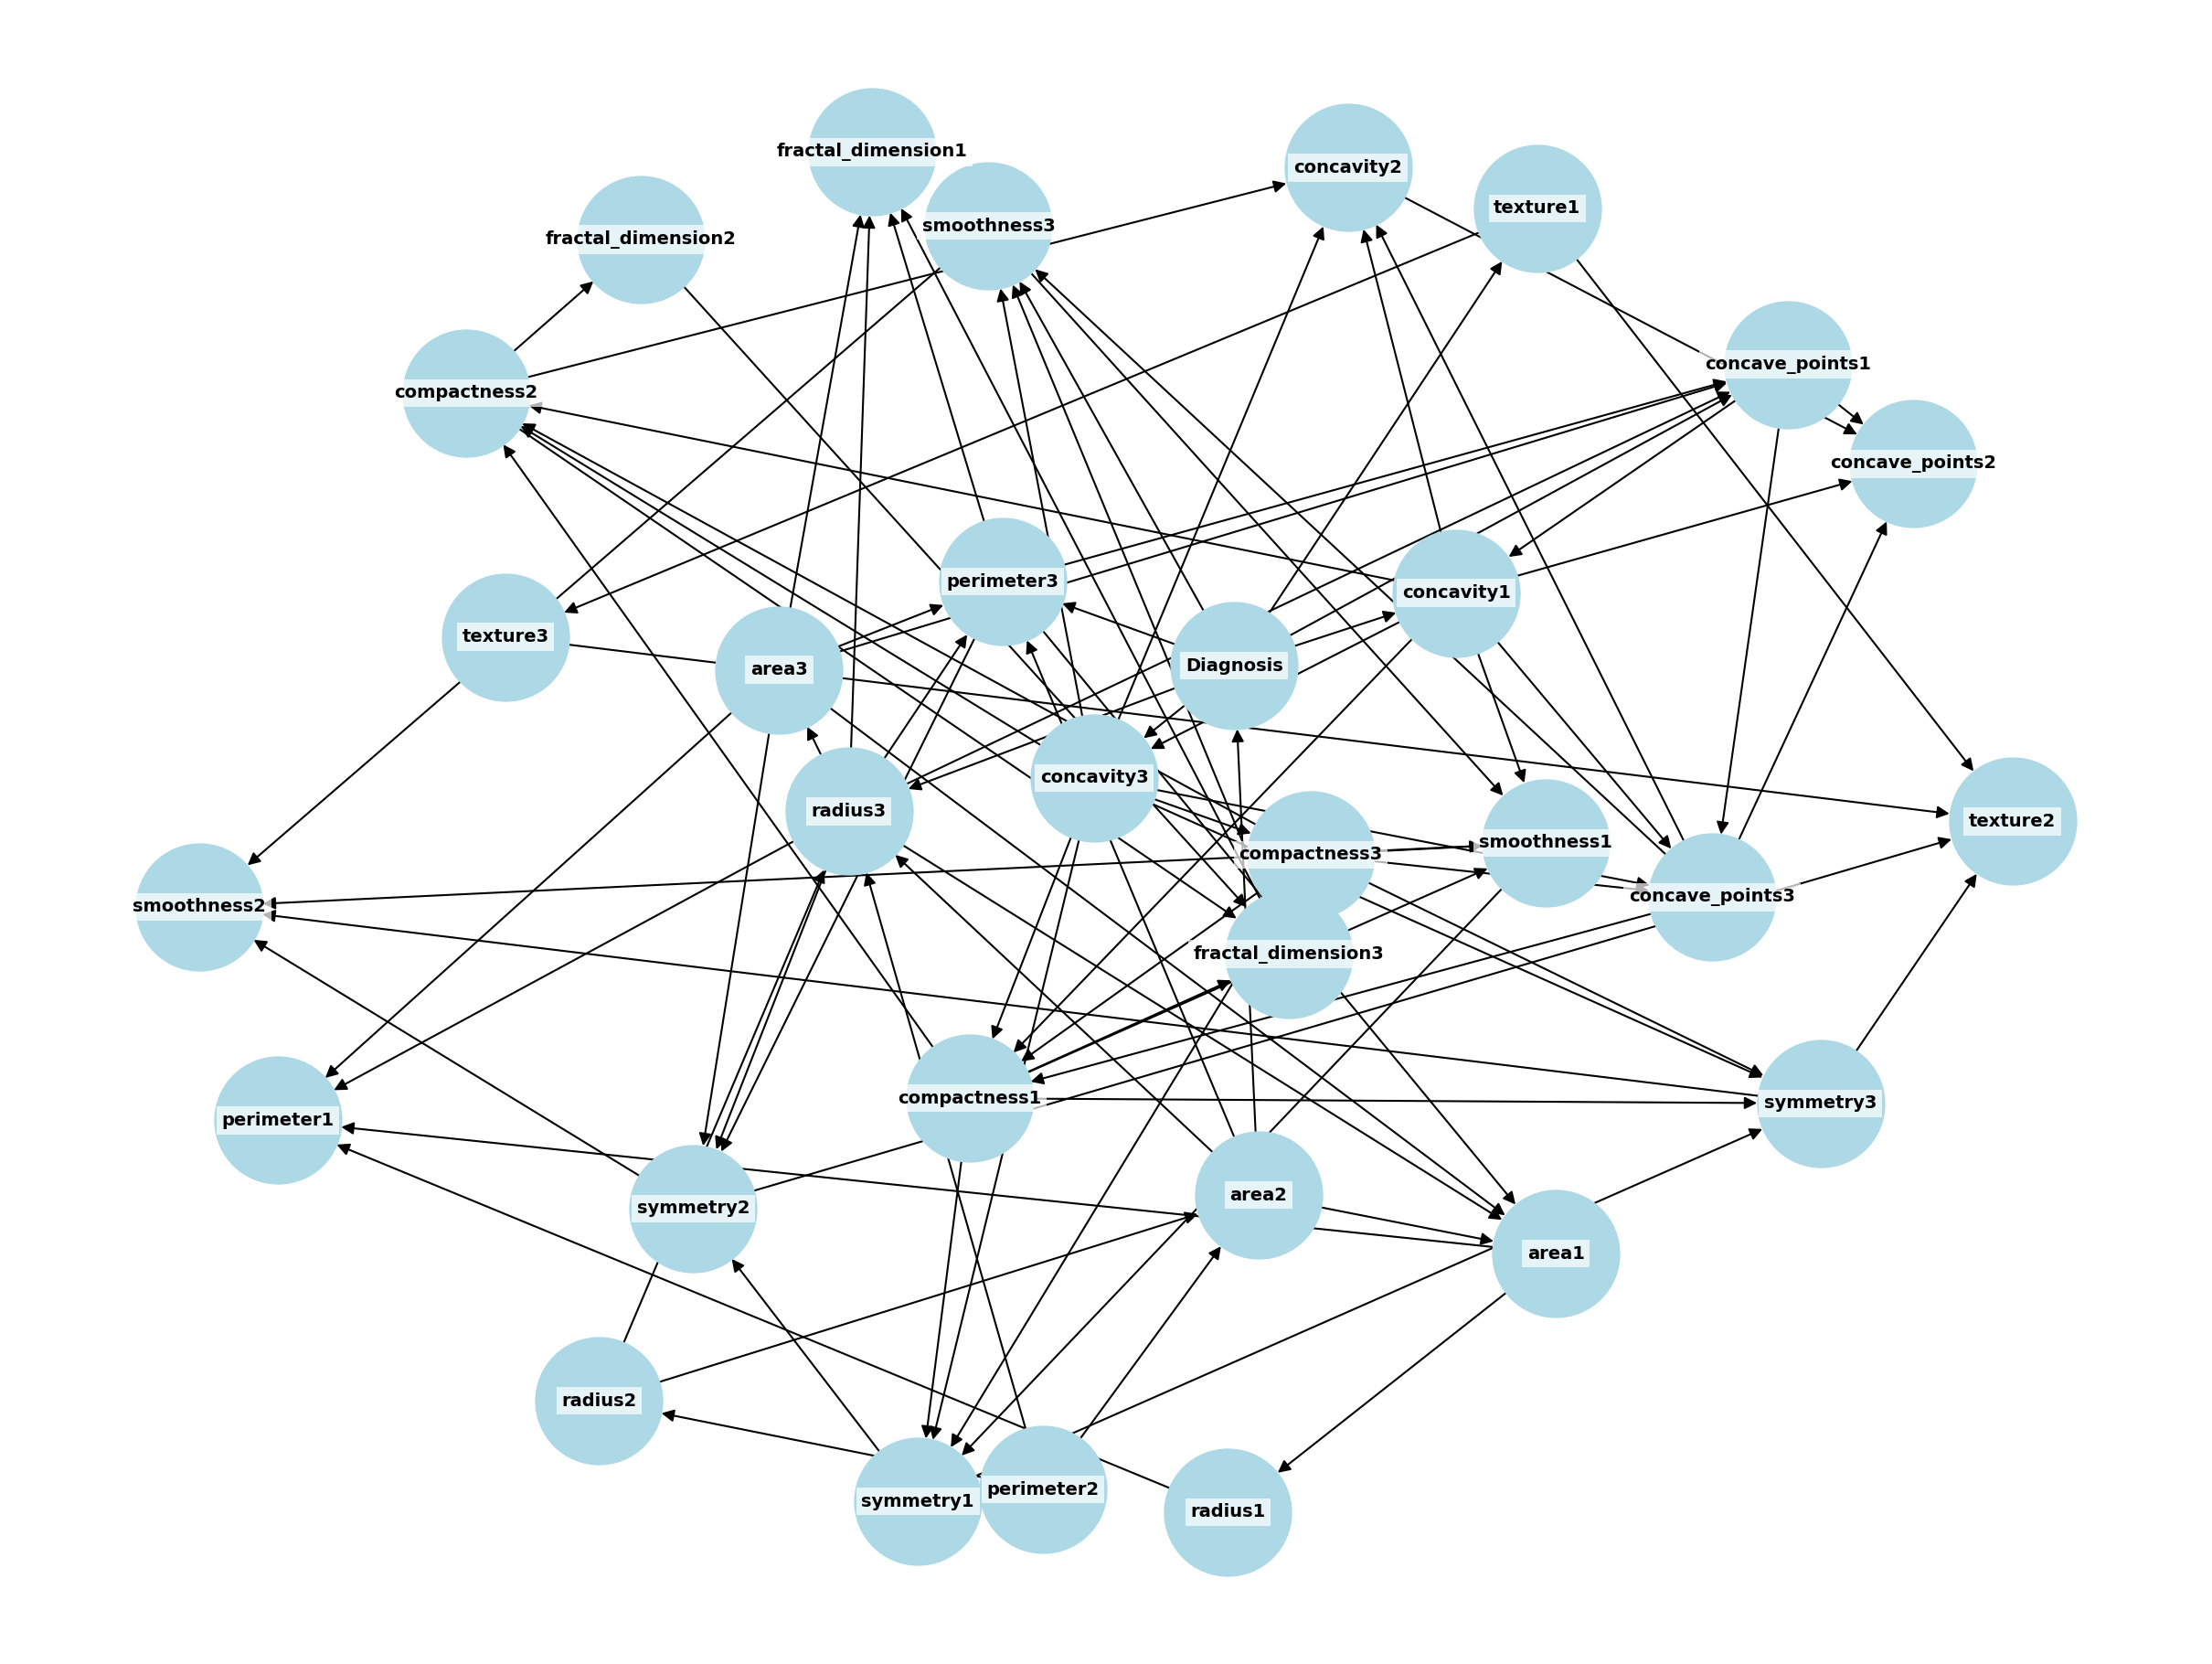

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()
G.add_edges_from(structure)

# Set up the plot
plt.figure(figsize=(24, 18))
pos = nx.spring_layout(G, k=5, iterations=200, seed=445)

# Draw the graph
nx.draw(G, pos, with_labels=False, node_color='lightblue', 
        node_size=10000, 
        arrows=True, edge_color='black', width=1.5,  
        arrowsize=20)

# Add labels with a white background for better readability
labels = nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')
for label in labels.values():
    label.set_bbox(dict(facecolor='white', edgecolor='none', alpha=0.7))

# plt.title("Bayesian Network Structure", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()

Performing 10-fold CV: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]

Average Log-Likelihood: -15.108520002236402
Standard Deviation of Log-Likelihood: 6.6697591377612415
Accuracy in predicting Diagnosis: 0.9244288224956063
Precision: 0.9242611341422738
Sensitivity: 0.8915094339622641
Specificity: 0.9439775910364145
F1 Score: 0.9243176652164578
ROC AUC: 0.972543734474922


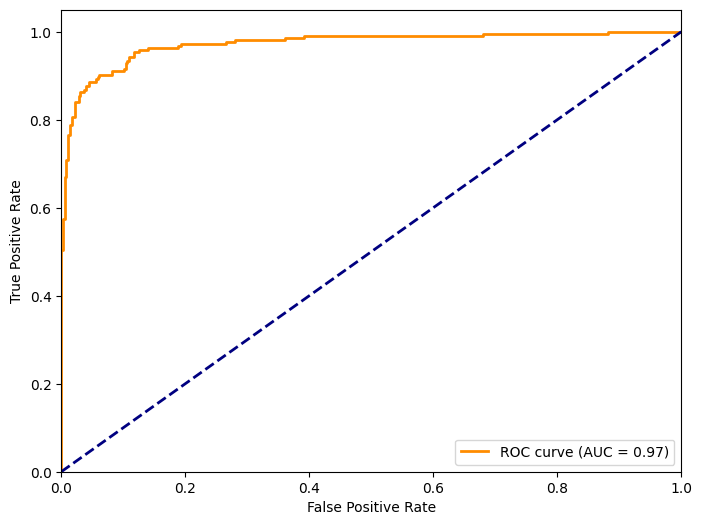

ROC AUC: 0.972543734474922


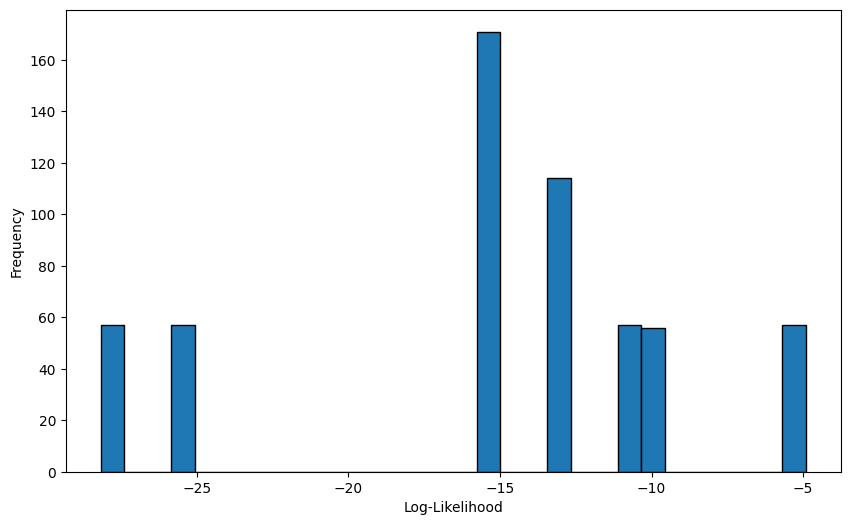

In [37]:
def calculate_Diagnosis_log_likelihood(model, data):
    inference = VariableElimination(model)
    log_likelihood = 0
    for _, row in data.iterrows():
        evidence = row.drop('Diagnosis').to_dict()
        cpd = inference.query(['Diagnosis'], evidence=evidence)
        prob = cpd.values[row['Diagnosis']]
        log_likelihood += np.log(prob)
    return log_likelihood

def kfold_cv_bayesian_network_Diagnosis(data, structure, n_splits=10):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    log_likelihoods = []
    predictions = []
    actuals = []
    probabilities = []
    n_classes = len(data['Diagnosis'].unique())
    
    for train_index, test_index in tqdm(kf.split(data), total=n_splits, desc="Performing 10-fold CV"):
        # Split the data
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        
        # Create and train the model
        model = BayesianNetwork(structure)
        model.fit(train_data, estimator=BayesianEstimator, prior_type="BDeu")
        
        # Calculate log-likelihood for the test set
        log_likelihood = calculate_Diagnosis_log_likelihood(model, test_data)
        log_likelihoods.extend([log_likelihood] * len(test_data))
        
        # Make predictions for Diagnosis
        inference = VariableElimination(model)
        for _, row in test_data.iterrows():
            evidence = row.drop('Diagnosis').to_dict()
            pred_cpd = inference.query(['Diagnosis'], evidence=evidence)
            prediction = pred_cpd.values.argmax()
            predictions.append(prediction)
            actuals.append(row['Diagnosis'])
            probabilities.append(pred_cpd.values)
    
    # Calculate metrics
    avg_log_likelihood = np.mean(log_likelihoods)
    tn, fp, fn, tp = confusion_matrix(actuals, predictions).ravel()
    accuracy = accuracy_score(actuals, predictions)
    precision = precision_score(actuals, predictions, average='weighted')
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = f1_score(actuals, predictions, average='weighted')
    
    # Calculate ROC AUC
    actuals_bin = label_binarize(actuals, classes=range(n_classes))
    if n_classes == 2:
        roc_auc = roc_auc_score(actuals_bin, np.array(probabilities)[:, 1])
    else:
        roc_auc = roc_auc_score(actuals_bin, np.array(probabilities), multi_class='ovr', average='weighted')
    
    return avg_log_likelihood, log_likelihoods, accuracy, precision, sensitivity, specificity, f1, roc_auc, actuals_bin, np.array(probabilities), actuals, predictions

# Assuming 'data' is your DataFrame and 'structure' is your network structure
avg_ll, all_ll, acc, precision, sensitivity, specificity, f1, roc_auc, actuals_bin, probabilities, actuals, predictions = kfold_cv_bayesian_network_Diagnosis(data, structure)

print(f"Average Log-Likelihood: {avg_ll}")
print(f"Standard Deviation of Log-Likelihood: {np.std(all_ll)}")
print(f"Accuracy in predicting Diagnosis: {acc}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")

# Reshape actuals_bin to be a 1D array
actuals_bin = actuals_bin.ravel()
# Use only the probabilities for the positive class (second column)
positive_probs = probabilities[:, 1]
# Calculate ROC AUC
roc_auc = roc_auc_score(actuals_bin, positive_probs)
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(actuals_bin, positive_probs)
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC: {roc_auc}")

# Plot log-likelihood distribution
plt.figure(figsize=(10, 6))
plt.hist(all_ll, bins=30, edgecolor='black')
# plt.title("Distribution of Log-Likelihoods in 10-fold CV (Diagnosis Prediction)")
plt.xlabel("Log-Likelihood")
plt.ylabel("Frequency")
plt.show()

In [38]:
def bootstrap_ci(metric_func, y_true, y_pred, alpha=0.05, n_bootstraps=1000):
    bootstrapped_scores = []
    for _ in range(n_bootstraps):
        indices = np.random.randint(0, len(y_true), len(y_true))
        score = metric_func(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    return np.percentile(bootstrapped_scores, [alpha/2 * 100, (1 - alpha/2) * 100])

accuracy_ci = bootstrap_ci(accuracy_score, np.array(actuals), np.array(predictions))
f1_ci = bootstrap_ci(lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'), 
                     np.array(actuals), np.array(predictions))
auc_ci = bootstrap_ci(roc_auc_score, actuals_bin.ravel(), probabilities[:, 1])

print(f"Accuracy: {acc:.3f} (95% CI: {accuracy_ci[0]:.3f}-{accuracy_ci[1]:.3f})")
print(f"F1 Score: {f1:.3f} (95% CI: {f1_ci[0]:.3f}-{f1_ci[1]:.3f})")
print(f"AUC: {roc_auc:.3f} (95% CI: {auc_ci[0]:.3f}-{auc_ci[1]:.3f})")

Accuracy: 0.924 (95% CI: 0.902-0.944)
F1 Score: 0.924 (95% CI: 0.902-0.946)
AUC: 0.973 (95% CI: 0.958-0.985)


Mean Prediction Entropy: 0.088 ± 0.182


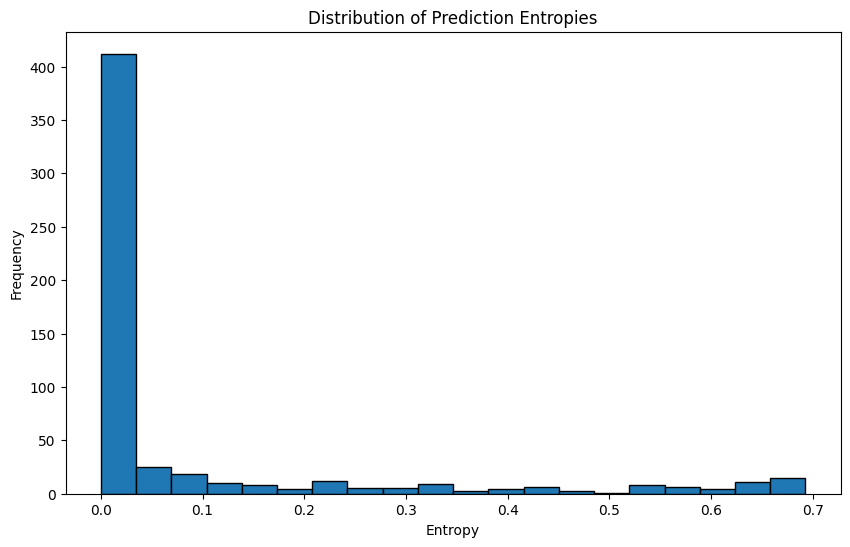

In [21]:
def prediction_entropy(probabilities):
    return entropy(probabilities, axis=1)

entropies = prediction_entropy(probabilities)
mean_entropy = np.mean(entropies)
std_entropy = np.std(entropies)

print(f"Mean Prediction Entropy: {mean_entropy:.3f} ± {std_entropy:.3f}")

plt.figure(figsize=(10, 6))
plt.hist(entropies, bins=20, edgecolor='black')
plt.title("Distribution of Prediction Entropies")
plt.xlabel("Entropy")
plt.ylabel("Frequency")
plt.show()

In [22]:
ll_mean = np.mean(all_ll)
ll_std = np.std(all_ll)
ll_ci = stats.t.interval(0.95, len(all_ll)-1, loc=ll_mean, scale=ll_std/np.sqrt(len(all_ll)))

print(f"Log-Likelihood: {ll_mean:.3f} ± {ll_std:.3f}")
print(f"95% CI for Log-Likelihood: ({ll_ci[0]:.3f}, {ll_ci[1]:.3f})")

Log-Likelihood: -15.109 ± 6.670
95% CI for Log-Likelihood: (-15.658, -14.559)
